> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

## 05 - Time Series Classification

This is an incomplete tutorial on time series classification using dataset from CareerCon 2019 competition ( https://www.kaggle.com/c/career-con-2019/data ). The dataset consists of features encoding the current angle on how the robot is oriented as a quartenion, angular velocity and linear acceleration. The target / label for this dataset is the type of surface that the robot is moving on.

## Notebook Description
This tutorial will show different approaches other than deep learning that can be applied to search for anomalies. All the techniques is readily available in Scikit-learn library. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into anomaly detection algorithms
2. Apply different anomaly detection algorithms readily accessible from Scikit-learn API
3. Compare and contrast performance of anomaly detection algorithms

## Notebook Outline
Below is the outline for this tutorial:
1. [A Little Bit of Theory](#theory)
2. [Choice of Dataset](#dataset)
3. [Baseline Performance](#baseline)
4. [Anomaly Detection Techniques](#techniques) 
    * a) [Isolation Forest](#isolation-forest)
    * b) [Minimum Covariance Determinant](#minimum-cov-determinant)
    * c) [Local Outlier Factor (LOF)](#lof)
    * d) [One-class Support Vector Machine (OCSVM)](#ocsvm)

5. [Exercise](#exercise)
6. [Reference](#reference)

##### Instructions
The Recurrent Neural Network (RNN) architecutres show impressive results in tasks related to time-series processing and prediction. In this kernel, we're going to build a very simple LSTM-based classifier as an example of how one can apply RNN to classify a time-series data.

Data Description

    X_[train/test].csv - the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:

    -row_id: The ID for this row.

    -series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.

    -measurement_number: Measurement number within the series.

The orientation channels encode the current angles how the robot is oriented as a quaternion (see Wikipedia). Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times. The 10 sensor channels are:

    orientation_X

    orientation_Y

    orientation_Z

    orientation_W

    angular_velocity_X

    angular_velocity_Y

    angular_velocity_Z

    linear_acceleration_X

    linear_acceleration_Y

    linear_acceleration_Z

    y_train.csv - the surfaces for training set.

    -series_id: ID number for the measurement series.

    -group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

    -surface: the target for this competition.

    sample_submission.csv - a sample submission file in the correct format.


In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import cpu_count
from pathlib import Path

In [4]:
# for reproducibility
seed = 1
np.random.seed(seed)

In [5]:
# set GPU (if available)
# torch.cuda.set_device(0)

In [6]:
print(Path.cwd().parent)

C:\Users\User\repo\Certifai\time-series-labs


### Loading The Data

First of all, we read the files and drop the irrelavant columns.

In [7]:
ROOT = Path.cwd().parent/'datasets'
SAMPLE = ROOT/'sample_submission.csv'
TRAIN = ROOT/'X_train.csv'
TARGET = ROOT/'y_train.csv'
TEST = ROOT/'X_test.csv'

ID_COLS = ['series_id', 'measurement_number']

x_cols = {
    'series_id': np.uint32,
    'measurement_number': np.uint32,
    'orientation_X': np.float32,
    'orientation_Y': np.float32,
    'orientation_Z': np.float32,
    'orientation_W': np.float32,
    'angular_velocity_X': np.float32,
    'angular_velocity_Y': np.float32,
    'angular_velocity_Z': np.float32,
    'linear_acceleration_X': np.float32,
    'linear_acceleration_Y': np.float32,
    'linear_acceleration_Z': np.float32
}

y_cols = {
    'series_id': np.uint32,
    'group_id': np.uint32,
    'surface': str
}

In [9]:
# unzip file
import zipfile
path_to_zip_file = str(ROOT) + "/career-con-2019.zip"
directory_to_extract_to = ROOT
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [10]:
x_trn = pd.read_csv(TRAIN, usecols=x_cols.keys(), dtype=x_cols)
x_tst = pd.read_csv(TEST, usecols=x_cols.keys(), dtype=x_cols)
y_trn = pd.read_csv(TARGET, usecols=y_cols.keys(), dtype=y_cols)

### PyTorch Wrappers

Before we can start training a torch model, we need to convert pandas data frames into PyTorch-specific data types. The main classes here are Dataset and DataLoader. The functions below split the dataset into training and validation subsets, and wrap them with data loaders.

In [11]:
def create_datasets(X, y, test_size=0.2, dropcols=ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc, test_size=0.1)
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, enc


def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl


def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

### Cyclic Learning Rate

The recent papers by L. Smith show us that the cyclic learning rate schedulers have very positive influence on model's convergence speed. In the following cells, we implement a simple cosine scheduler for our model.

In [12]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [13]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

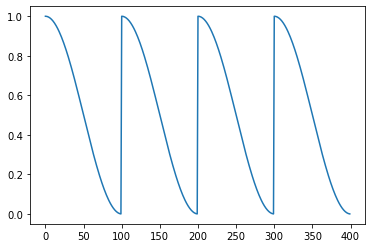

In [14]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

### The LSTM Model

Our classifier contains of several LSTM cells (hidden under the hood of nn.LSTM), and one nn.Linear layer. Note that we use batch_first=True to make sure that the first dimension of our tensors is interpreted as a batch size, and the next one - as a time dimension.

In [15]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
#         return [t.cuda() for t in (h0, c0)]
        return [t for t in (h0, c0)]

In [16]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn['surface'])

Preparing datasets


In [17]:
bs = 128
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=cpu_count())

Creating data loaders with batch size: 128


## Training Loop

Finally, we are ready to bring everything together and train the model.

In [19]:
input_dim = 10    
hidden_dim = 256
layer_dim = 3
output_dim = 9
seq_dim = 128

lr = 0.0005
n_epochs = 30
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
# model = model.cuda()
model = model
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch
#         x_batch = x_batch.cuda()
        y_batch = y_batch
#         y_batch = y_batch.cuda()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        sched.step()
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in val_dl:
#         x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        x_val, y_val = [t for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training
Epoch 1 best model saved with accuracy: 16.54%
Epoch 2 best model saved with accuracy: 19.69%
Epoch 3 best model saved with accuracy: 24.93%
Epoch:   5. Loss: 1.9750. Acc.: 19.16%
Epoch 8 best model saved with accuracy: 30.18%
Epoch:  10. Loss: 1.8285. Acc.: 24.93%
Epoch 11 best model saved with accuracy: 33.07%
Epoch 12 best model saved with accuracy: 34.91%
Epoch 14 best model saved with accuracy: 35.96%
Epoch:  15. Loss: 1.6292. Acc.: 34.38%
Epoch 16 best model saved with accuracy: 41.47%
Epoch:  20. Loss: 1.4431. Acc.: 43.57%
Epoch 20 best model saved with accuracy: 43.57%
Epoch 22 best model saved with accuracy: 45.14%
Epoch 23 best model saved with accuracy: 46.98%
Epoch:  25. Loss: 1.4166. Acc.: 47.51%
Epoch 25 best model saved with accuracy: 47.51%
Epoch 26 best model saved with accuracy: 48.82%
Epoch 27 best model saved with accuracy: 49.08%
Epoch 28 best model saved with accuracy: 51.97%
Epoch:  30. Loss: 1.3424. Acc.: 51.18%


In [20]:
print('The training is finished! Restoring the best model weights')

The training is finished! Restoring the best model weights


### Submission

Next, we load the best weights and run model on the testing dataset.

In [21]:
model.load_state_dict(torch.load('best.pth'))

<All keys matched successfully>

In [22]:
model.eval()

LSTMClassifier(
  (rnn): LSTM(10, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [23]:
test_dl = DataLoader(create_test_dataset(x_tst), batch_size=64, shuffle=False)

In [24]:
test = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
#     out = model(batch.cuda())
    out = model(batch)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += y_hat.tolist()

Predicting on test dataset


In [25]:
submit = pd.read_csv(SAMPLE)
submit['surface'] = enc.inverse_transform(test)
submit.to_csv('submit.csv', index=None)

## <a name="reference">Reference</a>:
1. [Deep Time Series Classification using PyTorch](https://www.kaggle.com/purplejester/a-simple-lstm-based-time-series-classifier)
2. [A Simple LSTM-Based Time-Series Classifier](https://www.kaggle.com/purplejester/pytorch-deep-time-series-classification)
3. [Starter Code for 3rd place Solution](https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution)
4. [CareerCon 2019 - Help Navigate Robots](https://www.kaggle.com/c/career-con-2019/data)